```{index} single: application; shortest path
```
```{index} networkx
```
```{index} network optimization
```
```{index} pandas dataframe
```

# Extra material: Shortest path problem in real life


In [1]:
import sys
import subprocess

class ColabInstaller:
    def __init__(self):
        reqs = subprocess.check_output([sys.executable, "-m", "pip", "freeze"])
        self.installed_packages = [r.decode().split("==")[0] for r in reqs.split()]

    def on_colab(self):
        return "google.colab" in sys.modules

    def install(self, package):
        if self.on_colab():
            subprocess.check_call(
                [sys.executable, "-m", "pip", "install", "-q", package]
            )
            self.installed_packages.append(package)

    def upgrade(self, package):
        if self.on_colab():
            subprocess.check_call(
                [sys.executable, "-m", "pip", "install", "-q", "--upgrade", package]
            )

if "google.colab" in sys.modules:
    colab = ColabInstaller()
    colab.install("numpy<2")
    colab.install("pandana")
    colab.install("osmnx")
    colab.install("osmnet")
    colab.install("mapclassify")
    colab.upgrade("matplotlib")
    colab.install("geopandas")
    colab.install("geopy")

# Introduction

Google brought with [maps]( https://www.google.com/maps) the world to our screens, including accurate geocoding and routing for several modalities. For the most, the usage of [maps]( https://www.google.com/maps) is interactive. As data and analytics professionals we often need a programmatically support for the services that [maps]( https://www.google.com/maps) offer us, preferably free. It also offers a plethora of [development support](https://developers.google.com/), but unfortunately most is paid. That is even more so for [maps]( https://developers.google.com/maps/documentation).

## Some background information and history
[Geoff Boeing]( https://geoffboeing.com/about/) is a true leader in demystifying urban data analytics, with a strong emphasis on street networks. His [peer reviewed publications]( https://geoffboeing.com/publications/) are open and accompanied by usable demonstrations using his own [OSMnx]( https://geoffboeing.com/2018/03/osmnx-features-roundup/) package.
Professor [Peter Sanders]( https://algo2.iti.kit.edu/english/sanders.php), see also his [Wikipedia]( https://en.wikipedia.org/wiki/Peter_Sanders_(computer_scientist)) page, has moved his interests to other areas but his [route planning]( http://algo2.iti.kit.edu/routeplanning.php) project shaped the world of truly scalable road routing algorithms.
From his alumni I distinguish two persons:
 * [Dominik Schultes](http://algo2.iti.kit.edu/schultes/) who won the [DIMACS challenge on shortest paths]( http://www.diag.uniroma1.it//challenge9/data/tiger/) and made it to the [Scientific American top 50]( https://www.scientificamerican.com/article/sciam-50-the-fastest-way/). Before Dominik’s research scalable shortest paths on large national road networks where heuristics, now they are exact and can be computed at world scale.
 * [Dennis Luxen]( http://algo2.iti.kit.edu/english/luxen.php) for creating https://github.com/Project-OSRM/osrm-backend which offers a free, scalable, implementation of [contraction hierarchies]( https://en.wikipedia.org/wiki/Contraction_hierarchies).

Finally, I mention [Fletcher Foti]( https://fletcherfoti.weebly.com/) who gave us [pandana]( http://udst.github.io/pandana/).



## Geocoding and map visualization

The world is mapped with the [geographic coordinate system](https://en.wikipedia.org/wiki/Geographic_coordinate_system) but we have difficulties remembering [latitudes]( https://en.wikipedia.org/wiki/Latitude) and [longitudes]( https://en.wikipedia.org/wiki/Longitude). We learn and remember the world better from addresses.

In [2]:
import osmnx as ox
import osmnet as osm
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import geopy
import folium
import networkx as nx
from IPython.display import display

In [3]:
def FreeLocator():
    return geopy.Photon(user_agent="myGeocoder")


def locate_geopy(description):
    location = FreeLocator().geocode(description)
    if location is not None:
        return location.latitude, location.longitude
    return None, None


pd.options.display.float_format = "{:.6f}".format

data = {
    "address": [
        "Centraal Station",
        "VU Hoofdgebouw",
        "Amsterdam Business School",
        "University of Amsterdam",
        "Johan Cruijff ArenA",
        "Ziggo Dome",
    ],
    "color": ["blue", "black", "orange", "green", "red", "purple"],
}

df = pd.DataFrame(data)
df["city"] = "Amsterdam"
df["country"] = "NL"

# Locate the latitude and longitude of each address
locations = [
    locate_geopy(",".join(row[["address", "city", "country"]]))
    for _, row in df.iterrows()
]
df["lat"] = [loc[0] for loc in locations]
df["lon"] = [loc[1] for loc in locations]
display(df)

Amsterdam = FreeLocator().geocode("Amsterdam, NL")

# Create a map centered around Amsterdam with markers for each the above locations
Map = folium.Map(location=(Amsterdam.latitude, Amsterdam.longitude), zoom_start=13)
for _, row in df.iterrows():
    folium.Marker(
        (row.lat, row.lon), icon=folium.Icon(color=row.color), tooltip=row.address
    ).add_to(Map)
Map

,address,color,city,country,lat,lon
0,Centraal Station,blue,Amsterdam,NL,52.378901,4.900581
1,VU Hoofdgebouw,black,Amsterdam,NL,52.334180,4.866901
2,Amsterdam Business School,orange,Amsterdam,NL,52.365107,4.911718
3,University of Amsterdam,green,Amsterdam,NL,52.368133,4.889804
4,Johan Cruijff ArenA,red,Amsterdam,NL,52.314353,4.942843
5,Ziggo Dome,purple,Amsterdam,NL,52.313407,4.937123


In [4]:
# Enable logging and caching for OSMnx
ox.settings.log_console = True
ox.settings.use_cache = True

In [5]:
%%time
# Create a graph from the OpenStreetMap data
G_walk = ox.graph_from_place('Amsterdam, NL', network_type='walk')

CPU times: user 23.3 s, sys: 427 ms, total: 23.7 s
Wall time: 23.9 s


In [6]:
# Print the number of nodes and edges in the graph
print(f"G_walk has {G_walk.number_of_nodes()} nodes and {G_walk.number_of_edges()} edges.")

G_walk has 48088 nodes and 134062 edges.


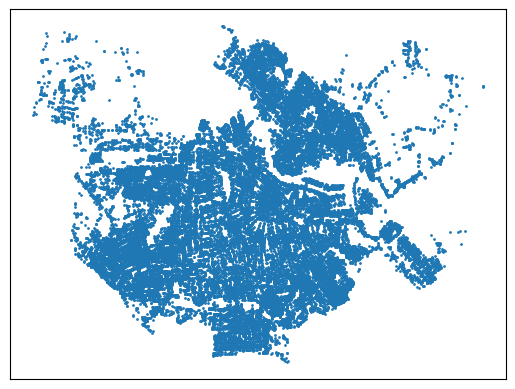

In [7]:
# Visualize the graph
node_positions = {
    node: (data["x"], data["y"]) for node, data in G_walk.nodes(data=True)
}
nx.draw_networkx_nodes(G_walk, pos=node_positions, node_size=1)
plt.show()

In [8]:
# Find the nearest nodes in the graph for each location
df["osmnx"] = ox.distance.nearest_nodes(G_walk, df.lon, df.lat)
df

,address,color,city,country,lat,lon,osmnx
0,Centraal Station,blue,Amsterdam,NL,52.378901,4.900581,5629072001
1,VU Hoofdgebouw,black,Amsterdam,NL,52.334180,4.866901,294648098
2,Amsterdam Business School,orange,Amsterdam,NL,52.365107,4.911718,46356661
3,University of Amsterdam,green,Amsterdam,NL,52.368133,4.889804,8121695895
4,Johan Cruijff ArenA,red,Amsterdam,NL,52.314353,4.942843,2680554148
5,Ziggo Dome,purple,Amsterdam,NL,52.313407,4.937123,2680554148


In [9]:
# Find the shortest path between the first two locations
%time route = nx.shortest_path(G_walk,df.iloc[0].osmnx,df.iloc[1].osmnx,weight='length')
print(route)

CPU times: user 223 ms, sys: 8.28 ms, total: 232 ms
Wall time: 83.6 ms
[5629072001, 5629072000, 5629071975, 4239313191, 4239313081, 4239313075, 4239312638, 4239312162, 6358902057, 11420679545, 11420679544, 11420679542, 3175727845, 10633464529, 10633464528, 9959600348, 9959600349, 9959600284, 9971788079, 9971788077, 9971788076, 9817686663, 9817686662, 10208267268, 6841663011, 6841663007, 6841654478, 8608994367, 8072948169, 6841636869, 6841636868, 12316269234, 6841645041, 6841680457, 6841680467, 6841680468, 6841680481, 8036446640, 8036446607, 8036446617, 8036446623, 8036446626, 9140788997, 8036446635, 8036446637, 3412535141, 3416675281, 3416675272, 3416675263, 3416675257, 6949114049, 6949114048, 10823781800, 6949114037, 6949114047, 6949114046, 5792613757, 46332984, 7191491361, 8852212652, 46331976, 46330373, 1976839698, 7191576329, 7191576325, 5805311952, 10073385072, 5805311930, 5805311950, 12343831161, 46321108, 46318613, 5805314256, 5805314261, 12241860172, 5805453836, 1342112320, 463

In [10]:
# explore the shortest route interactively
route_edges = ox.routing.route_to_gdf(G_walk, route, weight='length')
route_edges.explore(tiles="cartodbpositron", style_kwds={"weight": 5})

# Dijkstra on steroids for road networks

In [11]:
# Convert the graph to node and edge DataFrames
nodes = pd.DataFrame.from_dict(dict(G_walk.nodes(data=True)), orient="index")
edges = nx.to_pandas_edgelist(G_walk)

In [12]:
%%time
# Create a Pandana network
import pandana
network = pandana.Network(nodes['x'], nodes['y'], edges['source'], edges['target'], edges[['length']],twoway=True)

CPU times: user 2.01 s, sys: 34.7 ms, total: 2.05 s
Wall time: 2.07 s


In [13]:
network.nodes_df.head()

,x,y
6316199,4.888396,52.370173
25596455,4.923563,52.364840
25596477,4.906097,52.367000
25645989,4.925075,52.365727
25658579,4.930425,52.364536


In [14]:
network.edges_df.head()

,from,to,length
0,6316199,46379627,42.496919
1,6316199,46389218,225.577040
2,6316199,391355271,62.907067
3,25596455,8383889398,1.791003
4,25596455,46356773,41.699822


In [15]:
# Find the nearest nodes in the graph for each location
df["pandana"] = network.get_node_ids(df.lon, df.lat).values
df

,address,color,city,country,lat,lon,osmnx,pandana
0,Centraal Station,blue,Amsterdam,NL,52.378901,4.900581,5629072001,5629071974
1,VU Hoofdgebouw,black,Amsterdam,NL,52.334180,4.866901,294648098,294648098
2,Amsterdam Business School,orange,Amsterdam,NL,52.365107,4.911718,46356661,46356661
3,University of Amsterdam,green,Amsterdam,NL,52.368133,4.889804,8121695895,8121695901
4,Johan Cruijff ArenA,red,Amsterdam,NL,52.314353,4.942843,2680554148,10967577086
5,Ziggo Dome,purple,Amsterdam,NL,52.313407,4.937123,2680554148,10967577086


In [16]:
# Find the shortest path between the third and fourth locations
%time path_pandana = network.shortest_path(df.iloc[2].pandana, df.iloc[3].pandana)

CPU times: user 2.2 ms, sys: 1.51 ms, total: 3.71 ms
Wall time: 3.48 ms


In [17]:
# Find the shortest path between the third and fourth locations using NetworkX for comparison
%time path_nx = nx.shortest_path(G_walk,df.iloc[2].osmnx,df.iloc[3].osmnx,weight='length')

CPU times: user 6.54 ms, sys: 637 μs, total: 7.18 ms
Wall time: 7.04 ms


In [18]:
# Compare the paths found by Pandana and NetworkX
A = set(path_pandana)
B = set(path_nx)
(A | B) - (A & B)

{8121695895}

In [19]:
# Find the shortest path between all locations
origs = [o for o in df.pandana for d in df.pandana]
dests = [d for o in df.pandana for d in df.pandana]
%time distances = network.shortest_path_lengths(origs, dests)

CPU times: user 4.17 ms, sys: 959 μs, total: 5.12 ms
Wall time: 4.89 ms


In [20]:
# Create a distance matrix using 
n = len(df)
pd.options.display.float_format = "{:.2f}".format
pd.DataFrame(
    np.array(list(distances)).reshape(n, n), index=df.address, columns=df.address
)

address,Centraal Station,VU Hoofdgebouw,Amsterdam Business School,University of Amsterdam,Johan Cruijff ArenA,Ziggo Dome
address,,,,,,
Centraal Station,0.00,6836.32,2220.97,1462.39,6814.67,6814.67
VU Hoofdgebouw,6836.32,0.00,6215.02,5505.62,7342.21,7342.21
Amsterdam Business School,2220.97,6215.02,0.00,1861.46,5248.95,5248.95
University of Amsterdam,1462.39,5505.62,1861.46,0.00,6208.17,6208.17
Johan Cruijff ArenA,6814.67,7342.21,5248.95,6208.17,0.00,0.00
Ziggo Dome,6814.67,7342.21,5248.95,6208.17,0.00,0.00


In [21]:
# Create a random sample of origins and destinations nodes
np.random.seed(2025)
n = 500
sample = np.random.choice(
    np.array(network.nodes_df.index.values.tolist()), n, replace=False
)
origs = [o for o in sample for d in sample]
dests = [d for o in sample for d in sample]

In [22]:
# Calculate the shortest path lengths for all pairs of nodes in the sample
%time distances = network.shortest_path_lengths(origs, dests)
%time table = pd.DataFrame(np.array(list(distances)).reshape(n,n),index=sample,columns=sample)

CPU times: user 2.63 s, sys: 44.6 ms, total: 2.68 s
Wall time: 2.7 s
CPU times: user 6.97 ms, sys: 260 μs, total: 7.23 ms
Wall time: 7.26 ms


In [23]:
departure = table.max(axis=1).idxmax()
arrival = table.loc[departure].idxmax()
%time path_pandana = network.shortest_path(departure, arrival)
%time path_nx = nx.shortest_path(G_walk,departure,arrival,weight='length')
A = set(path_pandana)
B = set(path_nx)
(A | B) - (A & B)

CPU times: user 1.85 ms, sys: 168 μs, total: 2.02 ms
Wall time: 2.02 ms
CPU times: user 187 ms, sys: 8.52 ms, total: 195 ms
Wall time: 196 ms


set()

In [24]:
%time paths = network.shortest_paths(origs,dests)

CPU times: user 5.5 s, sys: 265 ms, total: 5.76 s
Wall time: 5.78 s


In [25]:
sum(map(len, paths))

38231214

In [26]:
for u, v in zip(paths[1][:-1], paths[1][1:]):
    print(G_walk.get_edge_data(u, v)[0].get("name", ""))

Ertskade
Ertskade
Ertskade
Ertskade
Ertskade
J.F. van Hengelstraat
J.F. van Hengelstraat
J.F. van Hengelstraat
C. van Eesterenlaan

C. van Eesterenlaan
C. van Eesterenlaan
C. van Eesterenlaan
C. van Eesterenlaan
C. van Eesterenlaan
C. van Eesterenlaan
C. van Eesterenlaan


Borneokade



Borneokade
Borneokade
Borneokade
Borneokade


Cruquiusweg
Panamalaan
Panamalaan
Cruquiuskade
Cruquiuskade
Cruquiuskade
Cruquiuskade
Cruquiuskade
Cruquiuskade
Dageraadsbrug
Sarphatistraat
Sarphatistraat
Sarphatistraat
Sarphatistraat
Sarphatistraat
Sarphatistraat
Sarphatistraat
Sarphatistraat
Sarphatistraat
Sarphatistraat
Sarphatistraat
Sarphatistraat
Sarphatistraat
Sarphatistraat
Sarphatistraat
Sarphatistraat
Sarphatistraat
Korte 's-Gravesandestraat
Sarphatistraat
Sarphatistraat
Sarphatistraat
Sarphatistraat
Sarphatistraat
Sarphatistraat
Sarphatistraat
Sarphatistraat
Sarphatistraat
Sarphatistraat
Sarphatistraat
Sarphatistraat
Sarphatistraat
Sarphatistraat
Sarphatistraat
Sarphatistraat
Sarphatistraat
Sarp

In [27]:
# explore the shortest path interactively
route_edges = ox.routing.route_to_gdf(G_walk, paths[1], weight='length')
route_edges.explore(tiles="cartodbpositron", style_kwds={"color": "red", "weight": 5})